# Feb 23, 2024: consensus clustering of modularity maximization

In [1]:

import os

import numpy as np 
import pandas as pd 
import pickle 
from tqdm import tqdm

import ants
from nipype.interfaces import afni

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from munkres import Munkres

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

240529-11:42:59,494 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
args.type = 'columnar'
args.roi_size = 'x'
args.maintain_symmetry = True
args.brain_div = 'ca2'
args.num_rois = 226


DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

PARCELS_path = f'{os.environ["HOME"]}/mouse_dataset/parcels'
BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi'
FC_path = f'{BASE_path}/{DESC}/func_nws'
DSJ_COMM_path = f'{BASE_path}/{DESC}/disjoint_comms'
NPY_path = f'{BASE_path}/{DESC}/npy_files'
ESTM_path = f'{BASE_path}/{DESC}/estimates'

args.num_comms = 7

In [4]:
parcels_img = ants.image_read(f'{PARCELS_path}/{DESC}_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/{DESC}_desc-labels.txt')

ValueError: File /home/govindas/mouse_dataset/parcels/type-columnar_size-x_symm-True_braindiv-ca2_nrois-226_desc-parcels.nii.gz does not exist!

---

In [ ]:
import glob

def create_dataframe(args, files):   
    dataset_df = []
    
    for file in tqdm(files):
        ssr = file.split('/')[-1].split('_')
        sub, ses, run = [ssr[i].split('-')[-1] for i in range(3)]
        df = pd.DataFrame({
            'sub':[int(sub[-2:])],
            'ses':[int(ses)],
            'run':[int(run)],
            'edges':[np.loadtxt(file).astype(int)],
        })
        dataset_df.append(df)
    dataset_df = pd.concat(dataset_df)
    return dataset_df.sort_values(
        by=['sub', 'ses', 'run'],
    ).reset_index(drop=True)

In [ ]:
dataset_df = create_dataframe(
    args, 
    files=glob.glob(f'{FC_path}/*.txt', recursive=True),
)

100%|██████████| 119/119 [00:00<00:00, 678.55it/s]


In [ ]:
def make_fc(args, edges):
    fc = np.zeros((args.num_rois, args.num_rois))
    fc[edges[:, 0], edges[:, 1]] = 1
    fc = (fc + fc.T)
    return fc

def comms(edges):
    print(edges.shape)
    fc = make_fc(args, edges)
    kmeans = KMeans(
        n_clusters=args.num_comms,
        init='k-means++', n_init=50,
        random_state=args.SEED,
    ).fit(fc)
    c = kmeans.predict(fc)
    comms = np.zeros((args.num_rois, args.num_comms))
    for comm in range(args.num_comms):
        comms[:, comm] = (c == comm).astype(int)
    return comms

dataset_df['dsj_comms'] = dataset_df['edges'].apply(comms)

(5085, 2)


(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)
(5085, 2)


In [ ]:
def reference_comms(args, X):
    X = np.concatenate(X, axis=-1)
    kmeans = KMeans(
        n_clusters=args.num_comms, 
        init='k-means++', n_init=50,
        random_state=args.SEED
    ).fit(X=X.T)
    print('found reference')
    return kmeans.cluster_centers_.T # num_rois x num_comms

def align_two_partitions(args, source_comms, target_comms):
    # align source onto target
    
    # distatnce matrix
    D = 1 - cosine_similarity(target_comms.T, source_comms.T)
    # Hungarian permutation method
    best_pi = list(zip(*Munkres().compute(D)))[1]
    source_comms = source_comms[:, best_pi]
    return source_comms, best_pi

def align_partitions(args, X):
    comm_cntrs = reference_comms(args, X)
    
    for idx, comms in tqdm(enumerate(X)):
        (
            comms, 
            best_pi,
        ) = align_two_partitions(
            args, 
            source_comms=comms, 
            target_comms=comm_cntrs
        )
        X[idx] = comms * (comms > args.thresh)
        X[idx] = np.round(X[idx], decimals=3)
    return X

In [ ]:
args.thresh = 0.15
dataset_df['dsj_comms'] = align_partitions(args, dataset_df['dsj_comms'].to_list())

found reference


119it [00:00, 1608.08it/s]


In [ ]:
def get_statistic(args, df, estim_cols):
    estims = []
    for idx, estim_col in enumerate(estim_cols):
        estim = np.mean(df[estim_col].to_list(), axis=0)
        estims.append(estim)
    return estims

X_dsj = get_statistic(
    args, 
    df=dataset_df,
    estim_cols=['dsj_comms'],
)[0]

In [ ]:
dataset_df

,sub,ses,run,edges,dsj_comms
0,1,1,1,"[[3, 1], [4, 3], [5, 0], [6, 3], [6, 4], [7, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0...."
1,1,1,3,"[[2, 0], [4, 3], [5, 0], [6, 3], [6, 4], [7, 0...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0...."
2,1,1,5,"[[5, 0], [5, 2], [6, 3], [6, 4], [7, 0], [7, 2...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1...."
3,1,1,7,"[[3, 1], [6, 3], [7, 1], [7, 5], [8, 1], [8, 3...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1...."
4,1,2,1,"[[1, 0], [3, 1], [5, 0], [6, 3], [6, 4], [7, 0...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...."
...,...,...,...,...,...
114,10,2,7,"[[2, 1], [3, 0], [3, 1], [4, 1], [4, 3], [5, 0...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1...."
115,10,3,1,"[[1, 0], [3, 0], [3, 1], [5, 0], [5, 1], [5, 2...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...."
116,10,3,3,"[[1, 0], [2, 0], [2, 1], [5, 0], [5, 1], [5, 2...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1...."
117,10,3,5,"[[1, 0], [2, 0], [5, 0], [5, 1], [5, 2], [6, 4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [1.0, 0...."


---

In [ ]:
# svinet mean mem. matrix
svinet_file = f'{ESTM_path}/{DESC}_k-{args.num_comms}_desc-svinet_meam_mbr.nii.gz'
svinet = ants.image_read(svinet_file).numpy()

X_svinet = np.zeros_like(X_dsj)
for idx, roi in enumerate(roi_labels):
    X_svinet[idx, :] = svinet[(parcels == roi)][0, :]

(6, 0, 5, 3, 2, 1, 4)


[Text(0.5, 1.0, 'kmeans'),
 Text(0.5, 13.90000000000002, 'comms.'),
 Text(419.19999999999993, 0.5, 'rois')]

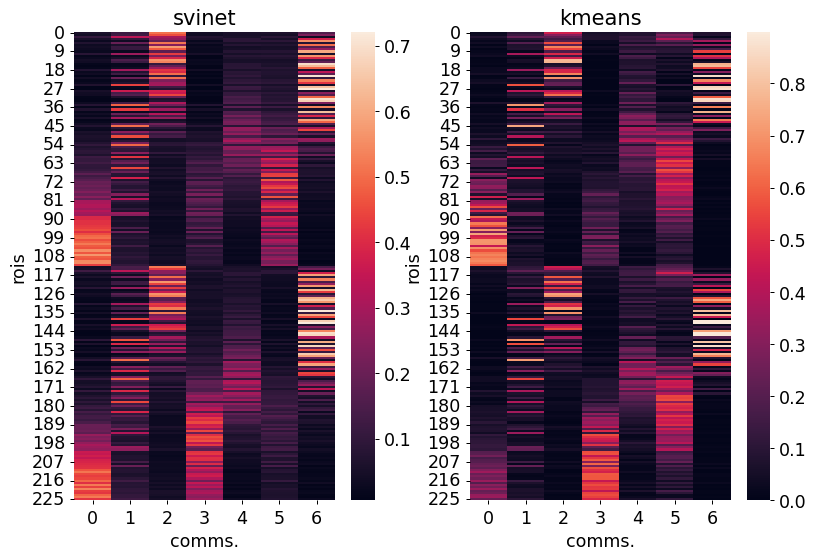

In [ ]:
# align results of two methods
X_dsj, best_pi = align_two_partitions(args, X_dsj, X_svinet)
print(best_pi)

fig, axs = plt.subplots(1, 2, figsize=(9, 6), dpi=90)
fig.tight_layout()
ax = axs[0]
sns.heatmap(X_svinet, ax=ax)
ax.set(title='svinet', xlabel='comms.', ylabel='rois')
ax = axs[1]
sns.heatmap(X_dsj, ax=ax)
ax.set(title='kmeans', xlabel='comms.', ylabel='rois')

In [ ]:
args.binwidth = 0.2
args.binrange = [0.2, 1.0]
def membership_proportions(X):
    bins = int((args.binrange[1] - args.binrange[0]) / args.binwidth)
    H = []
    for idx_comm in range(args.num_comms):
        y, _ = np.histogram(X[:, idx_comm], bins=bins, range=args.binrange)
        y = y / np.sum(y)
        H.append(y)
    H = np.nan_to_num(H)
    H = np.array(H).round(3)
    x = np.arange(args.binrange[0]+args.binwidth/2, args.binrange[1], args.binwidth)
    return H # num_comms x num_bins

H = membership_proportions(X_dsj)

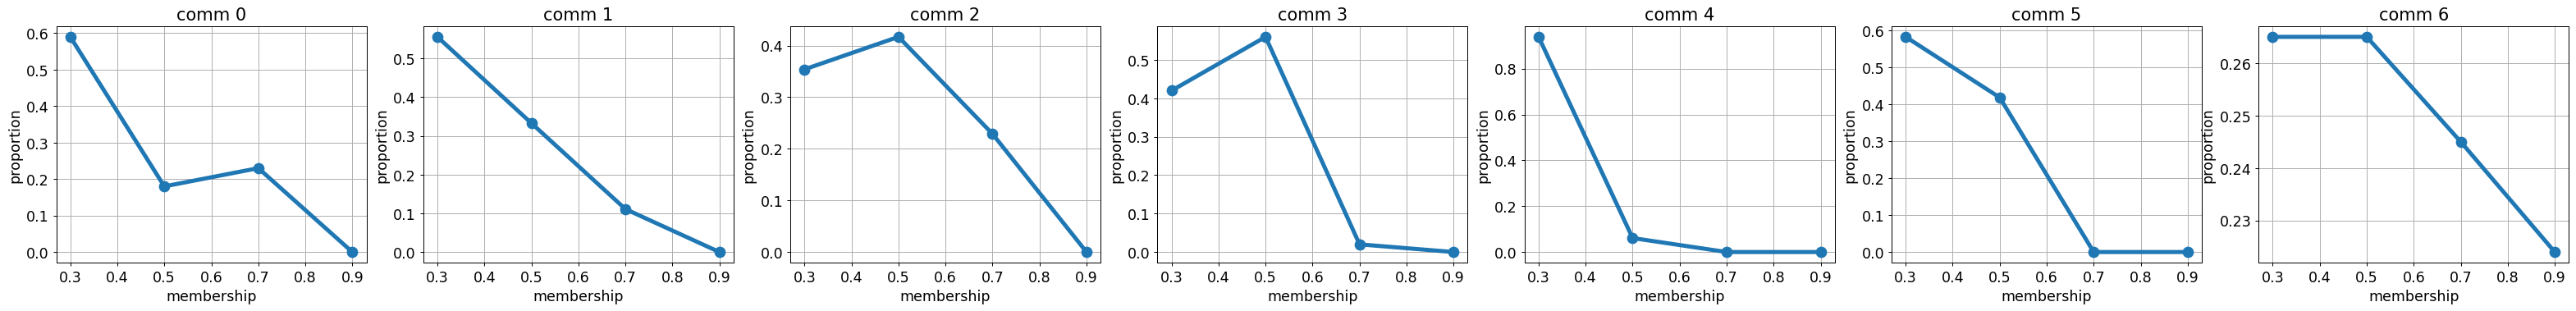

In [ ]:
x = np.arange(args.binrange[0]+args.binwidth/2, args.binrange[1], args.binwidth)

ncols = 7 
nrows = int(np.ceil((args.num_comms / ncols)))
fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, 
    figsize=(5*ncols, 4*nrows), dpi=90, 
    sharex=False, sharey=False
)
fig.tight_layout()
for idx_comm in range(args.num_comms):
    ax = axs[idx_comm // ncols, idx_comm % ncols] if nrows > 1 else axs[idx_comm]
    ax.plot(x, H[idx_comm, :], linewidth=4, markersize=10, marker='o', linestyle='-')
    ax.set(title=f'comm {idx_comm}', ylabel='proportion', )#ylim=[0.0, 0.7])
    if idx_comm // ncols == nrows-1: ax.set(xlabel='membership')
    ax.grid(True)

In [ ]:
def save_as_nifti(args, parcels_img, roi_labels, X, name):
    parcels = parcels_img.numpy()
    for comm in range(args.num_comms):
        comms_img = np.zeros_like(parcels)
        for idx, roi in enumerate(roi_labels):
            comms_img += (parcels == roi) * X[idx, comm]

        parcels_img.new_image_like(
            comms_img
        ).to_filename(f'{ESTM_path}/comm{comm}.nii.gz')

    out_file = f'{ESTM_path}/{DESC}_k-{args.num_comms}_desc-{name}_meam_mbr.nii.gz'
    try:
        os.remove(out_file)
    except:
        pass

    tcat = afni.TCat()
    tcat.inputs.in_files = [
        f'{ESTM_path}/comm{comm}.nii.gz'
        for comm in range(args.num_comms)
    ]
    tcat.inputs.out_file = out_file
    tcat.inputs.rlt = ''
    tcat.cmdline
    res = tcat.run()

    for comm in range(args.num_comms):
        try:
            os.remove(f'{ESTM_path}/comm{comm}.nii.gz')
        except:
            pass

In [ ]:
save_as_nifti(args, parcels_img, roi_labels, X_dsj, 'kmeans')

240227-17:23:57,34 nipype.interface INFO:
	 stderr 2024-02-27T17:23:57.034687:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
240227-17:23:57,39 nipype.interface INFO:
	 stderr 2024-02-27T17:23:57.039488:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
240227-17:23:57,42 nipype.interface INFO:
	 stderr 2024-02-27T17:23:57.042076:*+ WARNING: Set TR of output dataset to 1.0 s
240227-17:23:57,116 nipype.interface INFO:
	 stderr 2024-02-27T17:23:57.116369:++ elapsed time = 0.1 s
